In [180]:
import sys
import logging
import matplotlib.pyplot as plt
import cstrees.cstree as ct
import cstrees.scoring as sc
import cstrees.stage as st
import cstrees.learning as ctl
import networkx as nx
import numpy as np
%load_ext autoreload
%autoreload 2
#logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
from cstrees import csi_relation

ci = csi_relation.CI({1,2}, {3,4},{5})
print(ci)
dec = csi_relation.decomposition(ci)
for d in dec:
    print(d)

X1, X2 ⊥ X3, X4 | X5
X1 ⊥ X3 | X5
X1 ⊥ X4 | X5
X2 ⊥ X3 | X5
X2 ⊥ X4 | X5


In [182]:
wk = csi_relation.weak_union(ci)
for w in wk:
    print(w)

X1, X2 ⊥ X4 | X3, X5
X1, X2 ⊥ X3 | X4, X5
X2 ⊥ X3, X4 | X1, X5
X1 ⊥ X3, X4 | X2, X5


In [183]:
print("Original CI: ", ci)
pw = csi_relation.pairwise_cis(ci)
print("Pairwise CIs:")
for x in pw:
    print(x)

Original CI:  X1, X2 ⊥ X3, X4 | X5
Pairwise CIs:
X1 ⊥ X3 | X2, X4, X5
X1 ⊥ X4 | X2, X3, X5
X2 ⊥ X3 | X1, X4, X5
X2 ⊥ X4 | X1, X3, X5


In [184]:
c = csi_relation.Context({6:0})
csi = csi_relation.CSI(ci, c)

print("Original CSI: ", csi)
pw = csi_relation.pairwise_csis(csi)
print("Pairwise CSIs:")
for x in pw:
    print(x)

Original CSI:  X1, X2 ⊥ X3, X4 | X5, X6=0
Pairwise CSIs:
X1 ⊥ X3 | X2, X4, X5, X6=0
X1 ⊥ X4 | X2, X3, X5, X6=0
X2 ⊥ X3 | X1, X4, X5, X6=0
X2 ⊥ X4 | X1, X3, X5, X6=0


      a  b  c
0     2  2  2
1     1  0  1
2     1  0  0
3     1  0  0
4     0  0  0
...  .. .. ..
4996  1  0  0
4997  1  0  0
4998  0  0  0
4999  1  0  0
5000  1  0  0

[5001 rows x 3 columns]


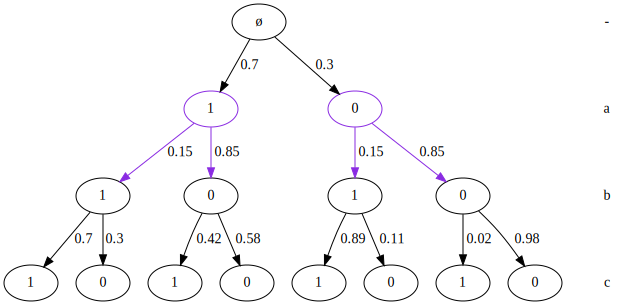

In [396]:
np.random.seed(6)
tree = ct.CStree([2] * 3, labels=["a", "b", "c"])

# V-structure
tree.update_stages({
    0: [st.Stage([{0, 1}])],
    1: [st.Stage([0, 0]), st.Stage([0, 1]), st.Stage([1, 0]), st.Stage([1, 1])]})

tree.sample_stage_parameters(alpha=1.0)

a = tree.plot()

# a.draw("testplot.png")
x = tree.sample(5000)
print(x)

true_cdags = tree.to_minimal_context_graphs()
for key, val in true_cdags.items():
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_true.png",
                args='-Glabel="'+str(key)+'"   ')
a


In [397]:

order = ["a", "b", "c"]
# Should order be expressed as the labels or as the levels?
# labels seems more natural but may include strings then which is a bit ugly.

# This is the order of the data columns.
s1 = sc.score_order(order, x, max_cvars=2, alpha_tot=1.0, method="BDeu", strategy="posterior")
print(s1)


score at level 0 : -3116.1202505997753
score at level 1 : -2123.9198080480464
score at level 2 : -3033.305429574885
-8273.345488222707


In [398]:
#order = [0, 2, 1]
order = ["a", "c", "b"]  # We know that b should not be to the very right.
s2 = sc.score_order(order, x, max_cvars=2, alpha_tot=1.0, method="BDeu", strategy="posterior")
print(s2)


score at level 0 : -3116.1202505997753
score at level 1 : -3292.9646008758737
score at level 2 : -2123.9068190918438
-8532.991670567493


optimal order: ['b', 'a', 'c'], score -8222.118920345132
stages :{0: [<cstrees.stage.Stage object at 0x7febb944ac20>], 1: [<cstrees.stage.Stage object at 0x7febb94488e0>, <cstrees.stage.Stage object at 0x7febb9449f60>], 2: [], -1: [<cstrees.stage.Stage object at 0x7febbaa30e80>]}

Optimal CStree stagings per level:
level 0:
[]
level 1:
[0]
[1]
level 2:


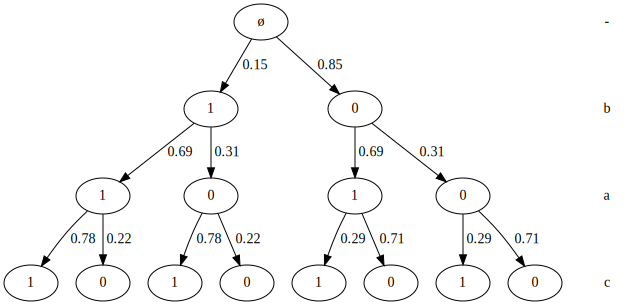

In [399]:
optord, score = ctl._find_optimal_order(
    x, strategy="posterior", max_cvars=2, alpha_tot=1.0, method="BDeu")
print("optimal order: {}, score {}".format(optord, score))

opttree = ctl._optimal_cstree_given_order(optord, x, max_cvars=2,
                             alpha_tot=1.0, method="BDeu")
print("stages :{}".format(opttree.stages))

print("\nOptimal CStree stagings per level:")
for key, val in opttree.stages.items():
    if key == -1:
        continue
    print("level {}:".format(key))
    for val2 in val:
        print(val2)
opttree.estimate_stage_parameters(x, alpha_tot=1.0, method="BDeu")
opttree.plot()


In [189]:
opt_cdags = opttree.to_minimal_context_graphs()
for key, val in opt_cdags.items():
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_opt.png",
                args='-Glabel="'+str(key)+'"   ')


In [190]:
tree = ctl.find_optimal_cstree(x, max_cvars=2, alpha_tot=1.0, method="BDeu")

tree.to_df()


,a,b,c
0,2,2,2
1,*,-,-
2,0,0,-
3,1,0,-
4,0,1,-
5,1,1,-


In [400]:
order = ["a", "b", "c"]
orderscore = sc.score_order(order, x, strategy="posterior", max_cvars=2, alpha_tot=1.0, method="BDeu")
nodescores = [sc._score_order_at_level(order, level, x, strategy="posterior", max_cvars=2, alpha_tot=1.0, method="BDeu") for level in range(len(order))]
print(orderscore)
print(nodescores)
print(np.sum(nodescores))
neig = ctl.get_relocation_neighborhood(order, 1, orderscore, nodescores, x, max_cvars=2, alpha_tot=1.0, method="BDeu")
print(order)
print("nodescores: ", nodescores)

print("neig: ", list(neig))


score at level 0 : -3116.1202505997753
score at level 1 : -2123.9198080480464
score at level 2 : -3033.305429574885
-8273.345488222707
[-3116.1202505997753, -2123.9198080480464, -3033.305429574885]
-8273.345488222707
['a', 'b', 'c']
nodescores:  [-3116.1202505997753, -2123.9198080480464, -3033.305429574885]
neig:  [0.4999999999999138, 0.4999999999999138, 8.631092375820474e-114]


In [456]:
orders, scores = ctl.gibbs_order_sampler(100000, x, max_cvars=2, alpha_tot=1.0, method="BDeu")

Calculating positional order scores for each variable: 100%|██████████| 3/3 [00:00<00:00, 1493.88it/s]


initial order: ['a', 'b', 'c']
initial score: -8273.345488222707


100%|██████████| 99999/99999 [00:24<00:00, 4079.03it/s]


In [455]:
set(scores)

{-8273.345488222707}

In [444]:
orders

[['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a', 'c'],
 ['b', 'a', 'c'],
 ['a', 'b', 'c'],
 ['b', 'a'

In [ ]:
x

In [ ]:
import pp
scores = sc.score_tables(x)
pp(scores)

In [374]:
oscores = sc.order_score_tables(x)

In [ ]:
oscores

In [366]:
sc.score_order_tables(["a", "b", "c"], oscores)

score: -3116.1202505997753
score: -2123.9198080480464
score: -3033.305429574885


-8273.345488222707

In [367]:
sc.score_order_tables(["a", "c", "b"], oscores)

score: -3116.1202505997753
score: -3292.9646008758737
score: -2123.9068190918438


-8532.991670567493

In [387]:
p = 10
cards = [2] * p

t = ct.sample_cstree(cards, 2, 0.5, 1)
#t.plot()
t.sample_stage_parameters()


In [388]:
x2 = t.sample(5000)

In [390]:
scores2 = sc.score_tables(x2)

In [392]:
pp(scores2)

{
    0: {
        '1=0': -1535.242062798612,
        '1=0,2=0': -1280.2057323271874,
        '1=0,2=1': -259.77062746935474,
        '1=0,3=0': -952.9662351103007,
        '1=0,3=1': -535.5449449716316,
        '1=0,4=0': -525.0780286705451,
        '1=0,4=1': -1014.727550691186,
        '1=0,5=0': -721.536979543173,
        '1=0,5=1': -708.2454592152583,
        '1=0,6=0': -401.54294240728217,
        '1=0,6=1': -496.91424204024224,
        '1=0,7=0': -690.9630743102271,
        '1=0,7=1': -655.0184847614912,
        '1=0,8=0': -621.427925051385,
        '1=0,8=1': -847.2125455780906,
        '1=0,9=0': -605.5809690532546,
        '1=0,9=1': -933.070024278732,
        '1=1': -1915.8913610337258,
        '1=1,2=0': -515.7920199419899,
        '1=1,2=1': -628.0071596180455,
        '1=1,3=0': -196.36089221583143,
        '1=1,3=1': -1287.884866922589,
        '1=1,4=0': -394.62269008731664,
        '1=1,4=1': -1526.1902729444182,
        '1=1,5=0': -1039.0259919238374,
        '1=1,5=1

In [395]:
oscores2 = sc.order_score_tables(x2)

100%|██████████| 10/10 [00:53<00:00,  5.38s/it]


In [394]:
oscores2


{0: {'None': -3448.670572984213,
  '1': -3448.5652124685553,
  '2': -3448.5652124685553,
  '3': -3448.5652124685553,
  '4': -3448.5652124685553,
  '5': -3448.5652124685553,
  '6': -3448.5652124685553,
  '7': -3448.5652124685553,
  '8': -3448.5652124685553,
  '9': -3448.5652124685553,
  '1,2': -3449.1320935232548,
  '1,3': -3449.1320935232548,
  '1,4': -3449.1320935232548,
  '1,5': -3449.1320935232548,
  '1,6': -3449.1320935232548,
  '1,7': -3449.1320935232548,
  '1,8': -3449.1320935232548,
  '1,9': -3449.1320935232548,
  '2,3': -3004.019850497307,
  '2,4': -3004.019850497307,
  '2,5': -3004.019850497307,
  '2,6': -3004.019850497307,
  '2,7': -3004.019850497307,
  '2,8': -3004.019850497307,
  '2,9': -3004.019850497307,
  '3,4': -3377.1795788946397,
  '3,5': -3377.1795788946397,
  '3,6': -3377.1795788946397,
  '3,7': -3377.1795788946397,
  '3,8': -3377.1795788946397,
  '3,9': -3377.1795788946397,
  '4,5': -3449.12774602947,
  '4,6': -3449.12774602947,
  '4,7': -3449.12774602947,
  '4,8':